### Interpret Results

In [1]:
# Run this script to add the src directory to the python path

from notebook_utils import modify_sys_path, get_src_dir_path

modify_sys_path()

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import re
from scipy.ndimage import gaussian_filter, zoom

from src.utils import calculate_min_Va_by_KL_threshold, calculate_min_Va_by_KL_rank

In [3]:
results_directory = 'results/moons/experiment_moons_6/'

zoom_level = 4

In [4]:
# Load the results
df_list = []
for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"results_" in filename:
        save_data = pd.read_csv(get_src_dir_path(results_directory) + filename)
        df_list.append(save_data)

In [5]:
D_data = None

for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"D_" in filename:
        D_data = pd.read_csv(get_src_dir_path(results_directory) + filename)

In [6]:
for save_data in df_list:
    # z_data = calculate_min_Va_by_KL_threshold(z_data, threshold=0.005, forward_kl=True)
    save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=5, forward_kl=True)

In [7]:
feature_columns = [col for col in D_data.columns if col != 'label' and col != 'note']

In [8]:

PROB_LABELS = ["0", "1"]

x_feature_list = []
total_uncertainty_list = []
kl_pyx_pyxz_list = []
kl_pyxz_pyx_list = []
min_Va_list = []    
max_Ve_list = []
z_value_for_min_Va_list = []

prob_y_xz_list = []
prob_y_x_list = []
within_threshold_list = []


for z_df in df_list:
    try:
        x_feature_list.append([z_df[f'x_{col}'].values[0] for col in feature_columns])
        min_Va = z_df["H[p(y|x,D)]"].values[0]
        total_uncertainty_list.append(min_Va)
        prob_y_xz = {}
        prob_y_x = {}
        # index where z_value_for_min_Va is True
        min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
        z_value_for_min_Va_list.append([z_df[f"z_{col}"].values[min_Va_index] for col in feature_columns])
        for label in PROB_LABELS:
            prob_y_xz[label] = z_df[f"p(y={label}|x,z,D)"].values[min_Va_index]
            prob_y_x[label] = z_df[f"p(y={label}|x,D)"].values[min_Va_index]
        prob_y_xz_list.append(prob_y_xz)
        prob_y_x_list.append(prob_y_x)
        kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
        kl_pyx_pyxz_list.append(kl_pyx_pyxz)
        kl_pyxz_pyx = z_df["kl_pyxz_pyx"].values[min_Va_index]
        kl_pyxz_pyx_list.append(kl_pyxz_pyx)
        min_Va = z_df["min_Va"].values[0]
        min_Va_list.append(min_Va)
        max_Ve = z_df["max_Ve"].values[0]
        max_Ve_list.append(max_Ve)
        
        within_threshold_list.append([z_df[z_df["within_threshold"]][f"z_{col}"].values for col in feature_columns])
        
    except:
        pass
    
# Create a dataframe from the lists
data = {
        'total_uncertainty': total_uncertainty_list,
        'min_Va': min_Va_list,
        'max_Ve': max_Ve_list,
        'kl_pyx_pyxz': kl_pyx_pyxz_list,
        'kl_pyxz_pyx': kl_pyxz_pyx_list,
        # 'z_value_for_min_Va': z_value_for_min_Va_list,
        # 'within_threshold': within_threshold_list
        }

data = {**{f"x_{col}": [d[i] for d in x_feature_list] for i, col in enumerate(feature_columns)}, **data}

data = {**data, **{f"z_{col}": [d[i] for d in z_value_for_min_Va_list] for i, col in enumerate(feature_columns)}}

data = {**data, **{f"within_threshold_{col}": [d[i] for d in within_threshold_list] for i, col in enumerate(feature_columns)}}

for label in PROB_LABELS:
    data[f"p(y={label}|x,z,D)"] = [d[label] for d in prob_y_xz_list]
    data[f"p(y={label}|x,D)"] = [d[label] for d in prob_y_x_list]

num_Va = len(min_Va_list)

# reduce the length of list to the number of num_Va
for key in data.keys():
    data[key] = data[key][:num_Va]

shots_df = pd.DataFrame(data)

shots_df = shots_df.sort_values(by=[f"x_{col}" for col in feature_columns])


In [9]:
shots_df

,x_x1,x_x2,total_uncertainty,min_Va,max_Ve,kl_pyx_pyxz,kl_pyxz_pyx,z_x1,z_x2,within_threshold_x1,within_threshold_x2,"p(y=0|x,z,D)","p(y=0|x,D)","p(y=1|x,z,D)","p(y=1|x,D)"
155,-1.5,-1.0,0.99729,0.09164,0.90565,0.000001,0.000001,-1.5,-1.0,[-1.5],[-1.0],0.529790,0.530633,0.470210,0.469367
69,-1.5,-0.8,0.94930,0.11494,0.83436,0.000025,0.000025,-1.5,-0.8,[-1.5],[-0.8],0.628360,0.631779,0.371640,0.368221
200,-1.5,-0.6,0.93784,0.12541,0.81243,0.000037,0.000037,-1.5,-0.6,[-1.5],[-0.6],0.641609,0.645715,0.358391,0.354285
139,-1.5,-0.4,0.84639,0.12664,0.71975,0.000043,0.000044,-1.5,-0.4,[-1.5],[-0.4],0.722374,0.726540,0.277626,0.273460
38,-1.5,-0.2,0.80961,0.13106,0.67855,0.000112,0.000113,-1.5,-0.2,[-1.5],[-0.2],0.744534,0.751050,0.255466,0.248950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2.3,1.0,0.89081,0.14074,0.75007,0.000035,0.000035,2.3,1.0,[2.3],[1.0],0.304132,0.307969,0.695868,0.692031
178,2.3,1.2,0.90745,0.15298,0.75447,0.000027,0.000027,2.3,1.2,[2.3],[1.2],0.319434,0.322845,0.680566,0.677155
52,2.3,1.4,0.89037,0.13502,0.75535,0.000025,0.000025,2.3,1.4,[2.3],[1.4],0.304361,0.307589,0.695639,0.692411
122,2.3,1.6,0.85636,0.13174,0.72462,0.000021,0.000021,2.3,1.6,[2.3],[1.6],0.277773,0.280668,0.722227,0.719332


In [10]:
feature_lengths = [len(shots_df[f"x_{col}"].unique()) for col in feature_columns]

feature_values = [shots_df[f"x_{col}"].unique() for col in feature_columns]

In [11]:
feature_ranges = []

for i, feature in enumerate(feature_columns):
    feature_ranges.append((feature_values[i][0], feature_values[i][-1]))
    
feature_ranges = np.array(feature_ranges)


In [12]:
feature_increment = np.round([feature_values[i][1] - feature_values[i][0] for i in range(len(feature_columns))],2)

In [13]:
extents = np.round([feature_ranges[i][0] - feature_increment[i]/2 for i in range(len(feature_columns))] + [feature_ranges[i][1] + feature_increment[i]/2 for i in range(len(feature_columns))],3)

extents = extents.reshape((2,len(feature_columns)))

extents = extents.T

extents = extents.flatten()

In [14]:
x1_ticks = np.arange(feature_ranges[0][0], feature_ranges[0][1] + feature_increment[0], feature_increment[0])
x2_ticks = np.arange(feature_ranges[1][0], feature_ranges[1][1] + feature_increment[1], feature_increment[1])

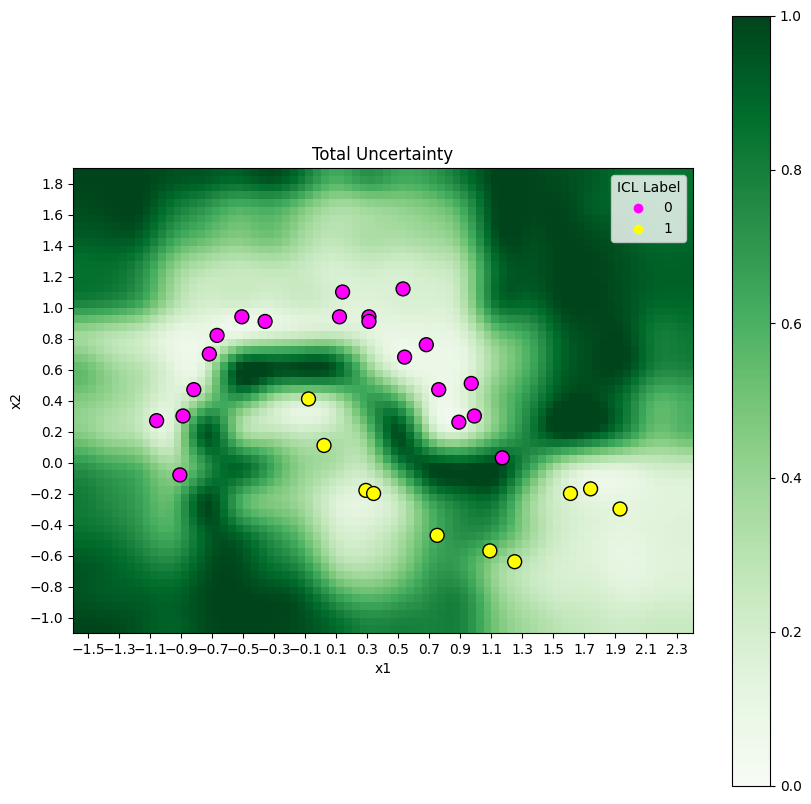

In [15]:
# Plot heatmap of total uncertainty
fig, ax = plt.subplots(figsize=(10, 10))
total_uncertainty = shots_df["total_uncertainty"].values.reshape(feature_lengths).T
cax = ax.matshow(zoom(total_uncertainty, zoom_level), origin="lower", extent=extents ,cmap='Greens', vmin=0, vmax=1)

# Add colorbar
cbar = fig.colorbar(cax)

ax.set_xticks(x1_ticks)
ax.set_yticks(x2_ticks)
ax.xaxis.set_ticks_position('bottom')


ax.set_xlabel(f"{feature_columns[0]}")
ax.set_ylabel(f"{feature_columns[1]}")
ax.set_title("Total Uncertainty")

scatter = ax.scatter(D_data['x1'], D_data['x2'], c=D_data['label'], label=D_data['label'], edgecolor='black', cmap='spring', s=100)
ax.legend(*scatter.legend_elements(), title="ICL Label")




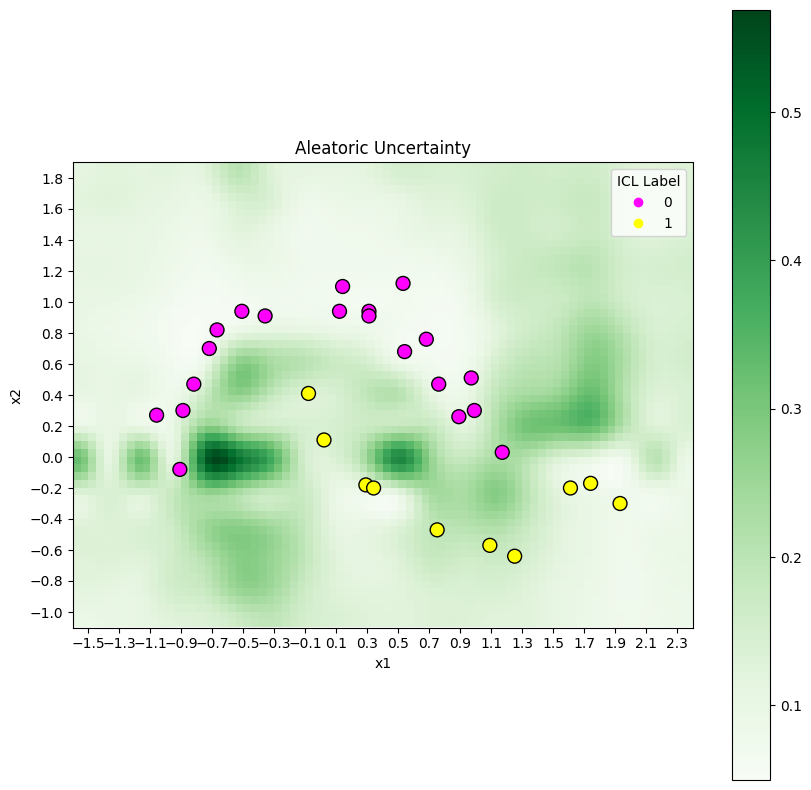

In [16]:
# Plot heatmap of total uncertainty
fig, ax = plt.subplots(figsize=(10, 10))
min_Va = shots_df["min_Va"].values.reshape(feature_lengths).T
cax = ax.matshow(zoom(min_Va, zoom_level), origin="lower", extent=extents ,cmap='Greens')

# Add colorbar
cbar = fig.colorbar(cax)

# Increase tick intervals
ax.set_xticks(x1_ticks)
ax.set_yticks(x2_ticks)
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel(f"{feature_columns[0]}")
ax.set_ylabel(f"{feature_columns[1]}")
ax.set_title("Aleatoric Uncertainty")

scatter = ax.scatter(D_data['x1'], D_data['x2'], c=D_data['label'], label=D_data['label'], edgecolor='black', cmap='spring', s=100)
ax.legend(*scatter.legend_elements(), title="ICL Label")


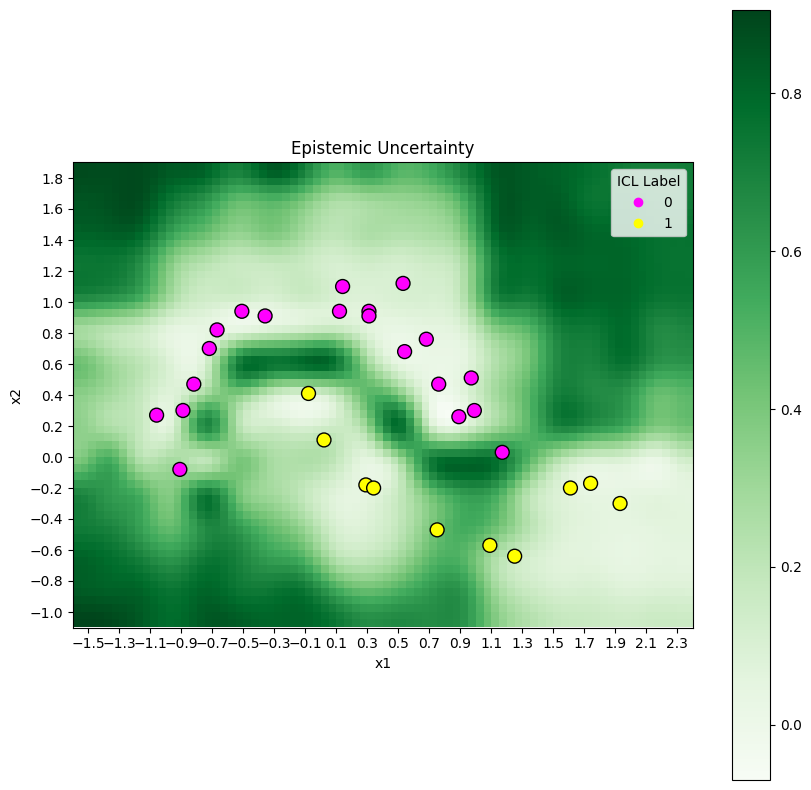

In [17]:
# Plot heatmap of epistemic uncertainty
fig, ax = plt.subplots(figsize=(10, 10))
epistemic_uncertainty = shots_df["max_Ve"].values.reshape(feature_lengths).T
cax = ax.matshow(zoom(epistemic_uncertainty, zoom_level), origin="lower", extent=extents ,cmap='Greens')

# Add colorbar
cbar = fig.colorbar(cax)

# Increase tick intervals
ax.set_xticks(x1_ticks)
ax.set_yticks(x2_ticks)
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel(f"{feature_columns[0]}")
ax.set_ylabel(f"{feature_columns[1]}")
ax.set_title("Epistemic Uncertainty")

scatter = ax.scatter(D_data['x1'], D_data['x2'], c=D_data['label'], label=D_data['label'], edgecolor='black', cmap='spring', s=100)
ax.legend(*scatter.legend_elements(), title="ICL Label")


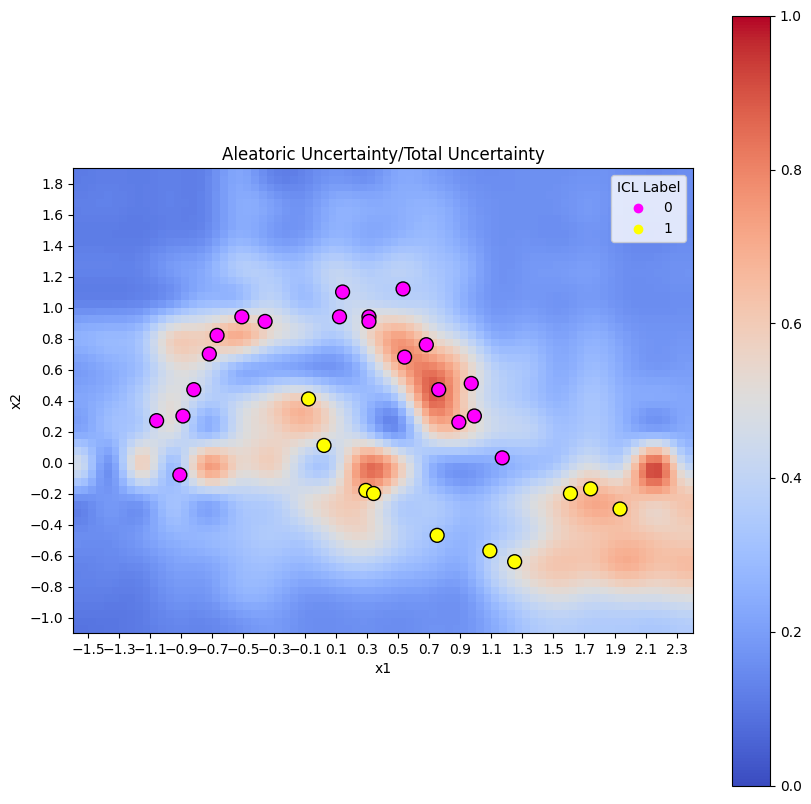

In [18]:
# Plot heatmap of aleatoric to epistemic uncertainty ratio
fig, ax = plt.subplots(figsize=(10, 10))
aleatoric_uncertainty = shots_df["min_Va"].values
total_uncertainty = shots_df["total_uncertainty"].values
ratio = aleatoric_uncertainty/total_uncertainty
ratio = ratio.reshape(feature_lengths).T
# Plot logarithmic color scale
cax = ax.matshow(zoom(ratio,zoom_level), origin="lower", extent=extents ,cmap='coolwarm', vmin=0, vmax=1)

# Add colorbar
cbar = fig.colorbar(cax)

# Increase tick intervals
ax.set_xticks(x1_ticks)
ax.set_yticks(x2_ticks)
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel(f"{feature_columns[0]}")
ax.set_ylabel(f"{feature_columns[1]}")
ax.set_title("Aleatoric Uncertainty/Total Uncertainty")

scatter = ax.scatter(D_data['x1'], D_data['x2'], c=D_data['label'], label=D_data['label'], edgecolor='black', cmap='spring', s=100)
ax.legend(*scatter.legend_elements(), title="ICL Label")

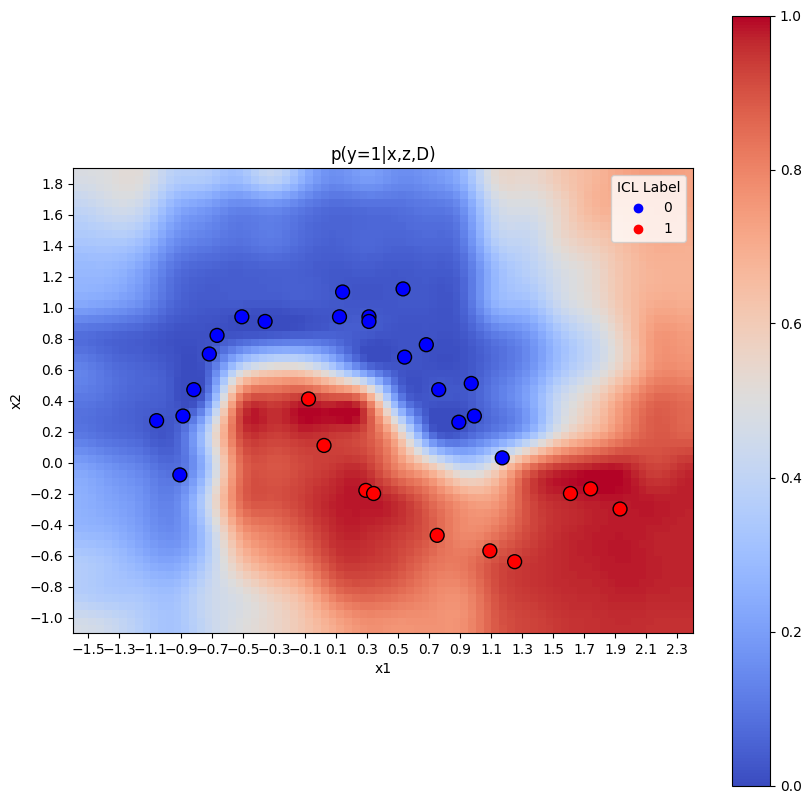

In [19]:
# Plot heatmap of probability
fig, ax = plt.subplots(figsize=(10, 10))
probability = shots_df["p(y=1|x,z,D)"].values.reshape(feature_lengths).T
cax = ax.matshow(zoom(probability, zoom_level), origin="lower", vmin=0, vmax=1, extent=extents ,cmap='coolwarm')

# Add colorbar
cbar = fig.colorbar(cax)

# Increase tick intervals
ax.set_xticks(x1_ticks)
ax.set_yticks(x2_ticks)
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel(f"{feature_columns[0]}")
ax.set_ylabel(f"{feature_columns[1]}")
ax.set_title("p(y=1|x,z,D)")

scatter = ax.scatter(D_data['x1'], D_data['x2'], c=D_data['label'], label=D_data['label'], edgecolor='black', cmap='bwr', s=100)
ax.legend(*scatter.legend_elements(), title="ICL Label")


In [20]:
D_data

,x1,x2,label,note
0,0.97,0.51,0,x1 = 0.97; x2 = 0.51
1,1.17,0.03,0,x1 = 1.17; x2 = 0.03
2,-0.72,0.70,0,x1 = -0.72; x2 = 0.7
3,1.09,-0.57,1,x1 = 1.09; x2 = -0.57
4,0.29,-0.18,1,x1 = 0.29; x2 = -0.18
5,0.31,0.94,0,x1 = 0.31; x2 = 0.94
6,0.14,1.10,0,x1 = 0.14; x2 = 1.1
7,1.74,-0.17,1,x1 = 1.74; x2 = -0.17
8,0.76,0.47,0,x1 = 0.76; x2 = 0.47
9,0.31,0.91,0,x1 = 0.31; x2 = 0.91
